In [1]:
import csv
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [2]:
torch.manual_seed(42)
d_opts = [('cuda', torch.cuda.is_available()), ('mps', torch.backends.mps.is_available()), ('cpu', True)]
device = next(device for device, available in d_opts if available)
print(f'using device: {device}')

using device: mps


In [36]:
data_csv = '../data/normalized_nasa_mars_images.csv'
with open(data_csv, mode='r') as f:
    reader = csv.reader(f)
    data = np.array([[np.float32(item) for item in row] for row in tqdm(reader, desc='loading csv data')])
    
# need to at random choose roughly 2100 of the 52,722 images labled 0 (other)
# to fix the skewed distribution of samples
n = int(0.85*len(data))
data_tr, data_val = data[:n], data[n:]
Xtr, Ytr = torch.from_numpy(data_tr[:, 1:]).to(device), torch.from_numpy(data_tr[:, 0]).to(device)
Xtr = Xtr.view(n, 50, 50)
Xval, Yval = torch.from_numpy(data_val[:, 1:]).to(device), torch.from_numpy(data_val[:, 0]).to(device)
Xval = Xval.view(len(data)-n, 50, 50)

loading csv data: 11101it [00:11, 942.01it/s]


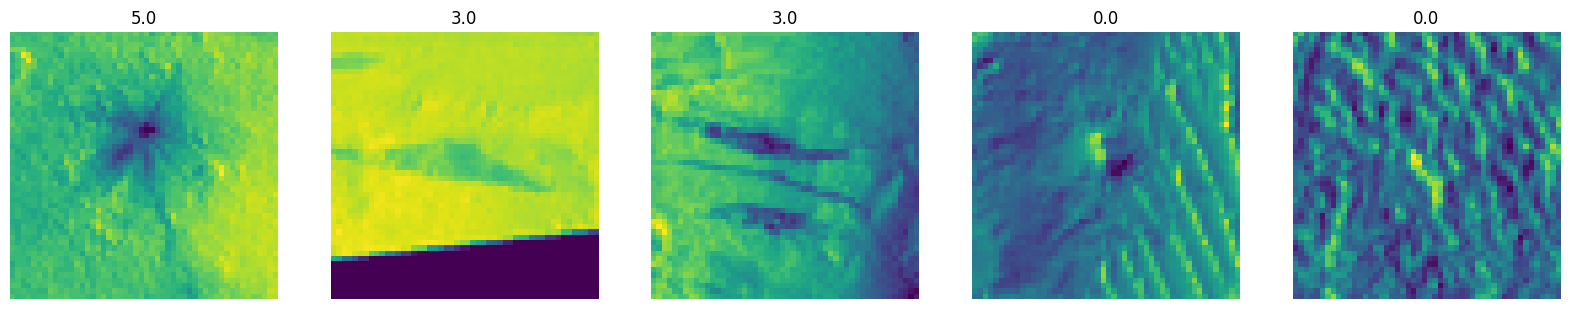

In [37]:
idxs = np.random.randint(Xtr.shape[0], size=5)
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, idx in enumerate(idxs):
    ax = axes[i]
    image = Xtr[idx].cpu().numpy()
    label = Ytr[idx].cpu().numpy()
    im = ax.imshow(image)
    ax.set_title(label)
    ax.axis('off')
plt.show();

{0: 2000, 1: 1900, 2: 766, 3: 1575, 4: 1654, 5: 476, 6: 1834, 7: 896}


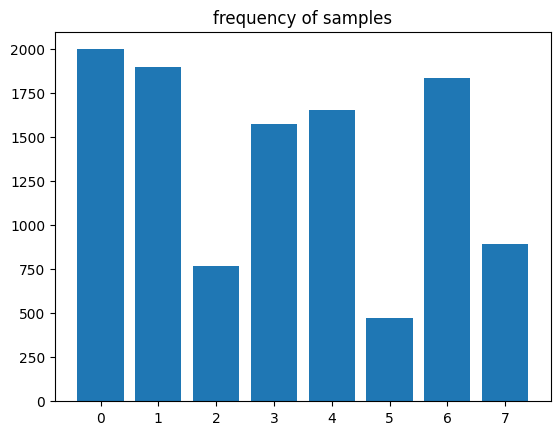

In [38]:
cc_list = torch.cat((Ytr, Yval)).tolist()
cc_dict = {}
for i in range(8):
    if i not in cc_dict:
        cc_dict[i] = 0
for i in cc_list:
    cc_dict[i] += 1

print(cc_dict)
plt.bar(cc_dict.keys(), cc_dict.values())
plt.title('frequency of samples')
plt.show();

In [39]:
input_size = 50
num_layers = 5
seq_len = 50
hidden_size = 128
num_classes = 8

batch_size = 32
learning_rate = 1e-3
epochs = 1000
epoch_eval = 100

In [40]:
class RNN(nn.Module):
    def __init__(self, in_size: int, h_size: int, n_layers: int, n_classes: int):
        super().__init__()
        self.h_size = h_size
        self.n_layers = n_layers
        self.rnn = nn.RNN(in_size, h_size, n_layers, batch_first=True)
        self.fc = nn.Linear(h_size*seq_len, n_classes)
    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.h_size).to(device)
        # forward prop
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

In [41]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
lossfn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [42]:
st = time.time()
for epoch in range(epochs):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    logits = model(Xb)
    loss = lossfn(logits, Yb)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    if epoch % epoch_eval == 0:
        print(f'{epoch} loss: {loss.item()}')
et = time.time()
print(f'training took: {et - st:.1f}s')

0 loss: 2.0898876190185547
100 loss: 2.047361373901367
200 loss: 1.6149182319641113
300 loss: 1.9069690704345703
400 loss: 1.9855302572250366
500 loss: 1.789299726486206
600 loss: 1.6558594703674316
700 loss: 1.5651451349258423
800 loss: 1.3153928518295288
900 loss: 1.388243317604065
training took: 107.3s


In [43]:
@torch.no_grad()
def split_loss(split: str):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
    }[split]
    logits = model(x.float())
    loss = lossfn(logits, y)
    print(split, loss.item())

with torch.inference_mode():
    split_loss('train')
    split_loss('val')

train 1.4952183961868286
val 3.6406867504119873


In [44]:
model.eval()
with torch.inference_mode():
    def accuracy_fn(y_true, y_pred):
        correct = torch.eq(y_true, y_pred).sum().item()
        acc = (correct / len(y_pred)) * 100
        return acc
    logits = model(Xval)
    acc = accuracy_fn(y_pred=logits.argmax(dim=1),
                     y_true=Yval)
    print(f'Accuracy: {acc:.2f}%')

Accuracy: 0.84%
